In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.optimize import minimize, rosen, rosen_der,root
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

%load_ext autoreload
%autoreload 2

from src import utils

In [2]:
N,n = 100,10
B = np.random.normal(0,1,size =(N,N))

A = B-B.T
I = np.eye(N)

Q = (I+A)@np.linalg.inv(I-A)

In [3]:
Q_n = Q[:,:n]
Q_n.T @ Q_n

Q_n.shape

(100, 10)

In [5]:
np.random.seed(0)

n = 20
num_trials = 10
g = 1.5

T_max = 40
num_steps = 20000
dt = T_max/num_steps
ts = np.linspace(0,T_max,num_steps)
u = np.zeros((n,num_steps))
B = np.zeros((n,n))


W = utils.create_random_weight_matrix(n = n, scale = g)

init_scale = 1

In [6]:
x = np.random.uniform(-5,5,(n,num_trials))

xs = np.zeros((n,num_trials,num_steps))

#Euler integrate
for step in range(num_steps):
  x += dt*utils.RNN_update(x,W)
  xs[:,:,step] = x

In [7]:
sol = root(fun = utils.RNN_update, x0 = xs[:,3,-1], jac=utils.RNN_update_jac, method='hybr',args = (W))
x_star = sol.x

J_star = utils.RNN_update_jac(sol.x,W)
utils.check_linear_stability(J_star)


'Matrix is linearly stable.'

In [57]:
M = utils.get_local_lyapunov_metric(J = J_star)

num_test_points = 10000

x_test_points = np.random.uniform(-1,1,(n,num_test_points))
y_test_points = x_test_points - np.expand_dims(x_star,1)
V_I = utils.V(M = M,Q = np.eye(n),x = y_test_points)

V_dot_I = utils.V_dot(M = M,W = W, Q = np.eye(n),x = y_test_points)

In [59]:
#Uses the sampling method of (Najevi et al, 2016) to find critical boundry of ellipse. 
c = np.inf
for i in range(num_test_points):
    if V_dot_I[i] >= 0 and V_I[i] < c:
        c = V_I[i]

c



12.251325604906139

In [64]:
#what is the projection of an ellipse?
x = np.arange(-5, 5,.1)# + center[0,:]
y = x.reshape(-1, 1)# + center[1,:]
X_mesh, Y_mesh = np.meshgrid(x, y)

h = two_dim_quad_form(M,X_mesh,Y_mesh)

cs = plt.contour(X_mesh+center[0,:],Y_mesh+ center[1,:],h,levels = [c,10])#,colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')

array([[ 1.38777878e-17,  1.38777878e-17,  0.00000000e+00,
        -1.56125113e-17,  6.93889390e-18, -6.93889390e-17,
         5.20417043e-18,  8.32667268e-17, -1.38777878e-17,
         2.77555756e-17,  2.42861287e-17,  0.00000000e+00,
         4.16333634e-17, -3.46944695e-17,  6.93889390e-18,
        -2.77555756e-17,  2.08166817e-17, -3.46944695e-17,
         0.00000000e+00,  2.94902991e-17],
       [-6.93889390e-17,  5.55111512e-17,  1.21430643e-17,
         3.46944695e-18,  2.77555756e-17,  5.55111512e-17,
         0.00000000e+00, -2.77555756e-17,  8.32667268e-17,
        -2.77555756e-17,  0.00000000e+00,  2.77555756e-17,
        -6.93889390e-17,  1.38777878e-17,  0.00000000e+00,
         1.11022302e-16, -3.46944695e-17,  0.00000000e+00,
        -2.77555756e-17,  2.77555756e-17],
       [ 6.93889390e-18, -1.38777878e-17, -3.46944695e-18,
         7.37257477e-18, -3.46944695e-18,  1.38777878e-17,
        -3.46944695e-18, -2.08166817e-17, -1.04083409e-17,
         1.38777878e-17, -1.0

In [9]:
xs_flattened = np.reshape(xs, newshape = (n,num_trials*num_steps))
#pca = PCA(n_components=3)
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)

xs_flattened_svd= svd.fit_transform(xs_flattened.T)

Q = svd.components_



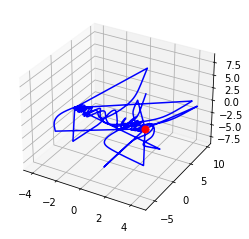

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')

#xs_flattened_projection = (Q @ xs_flattened).T

ax.plot(xs_flattened_svd[:,0],xs_flattened_svd[:,1],xs_flattened_svd[:,2],color = 'b')

#ax.plot(xs_flattened_projection[:,0],xs_flattened_projection[:,1],xs_flattened_projection[:,2],color = 'g')

x_star_pca = Q @ x_star

ax.scatter(x_star_pca[0],x_star_pca[1],x_star_pca[2],c = 'r',s = 50)



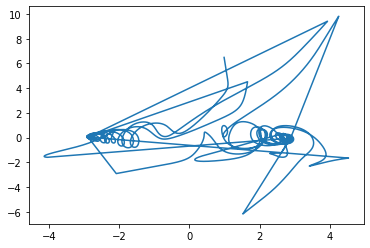

In [66]:
plt.plot(xs_flattened_svd[:,0],xs_flattened_svd[:,1])